<a href="https://colab.research.google.com/github/ariel-hedvat/AdvancedMLDLCourseAssignments/blob/main/NCF_with_Graph_ML_on_Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Collaborative Filtering Using Graph Machine Learning**
*Lukas Haas, Michal Skreta*

We implement LightGCN from scratch and apply it to the Spotify 1 Million Playlist Dataset to predict which songs belong to which playlist.

## **Installations**

Lets import all required packages first.

In [1]:
import torch
import pickle

In [2]:
torch.__version__

'2.2.1+cu121'

In [3]:
import os
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive
!pip install transformers

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=504020 sha256=5c66928b07e2cb74d842c2c0f525cfd6a6df8b3cbffc313cf8fc000d0cd98a03
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1071448 sha256=760b9e67509850c64b9ea2e4ec691d880e4c2bed2be8514b538ffd814e965a8d
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built 

In [4]:
import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_sparse import SparseTensor, matmul
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
print(torch_geometric.__version__)

2.5.1


In [5]:
import networkx as nx
from deepsnap.hetero_graph import HeteroGraph
import copy
from copy import deepcopy
import pickle

In [6]:
import deepsnap
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from sklearn.metrics import f1_score, roc_auc_score

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import json
from pathlib import Path as Data_Path
from os import listdir
from os.path import isfile, join
from itertools import combinations

In [9]:
from tqdm.notebook import tqdm

## **Loading the Dataset**

Since we can host the Spotify 1 Million Playlist Dataset ourselves due to copyright restrictions, head over to the offical challenge site to access and download the dataset.

**Spotify 1 Million Playlist Dataset**: https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge/dataset_files

**Important Note**:

The dataset, unzipped, is about 33.5 gigabytes of JSON files each containing 1'000 playlists with the songs they contain. Since this tutorial does not require all data, we will only work with the fist 100k playlists (or 100 files) in the data folder of the unzipped file.

Once you have downloaded the dataset, you have the following two options:

**Option 1**:
1. If your Google Colab environment has enough disk space and RAM, create an empty folder called "data" in the "files" section on Colab.
2. Upload the first 100 .json playlist files (first 100k playlists) of the dataset to the "data" folder.
3. Run the below "Loading the Dataset" code right here in Google Colab.

**Option 2**:
1. Download this Google Colab as a Juypter Notebook
2. Run the "Loading the Dataset" code locally on your machine
3. Name the resulting file "plst_track_artist_graph.txt"
4. Upload the resulting file to "files"
5. Proceed with the "Preprocessing the Dataset" section.

Let's check if your dataset upload was successful:

In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
MAIN_DIR = "drive/MyDrive/CS 224W Project_50"
DATA_PATH = Data_Path('spotify_million_playlist_dataset/data')
os.chdir(MAIN_DIR)

In [12]:
# DATA_PATH = Data_Path('data')

In [13]:
if not DATA_PATH.exists():
    print("Oops, file doesn't exist!")
else:
    print("Yay, the file exists!")

Yay, the file exists!


Let's look at a single example of a playlist.

In [14]:
file_names = [f for f in listdir(DATA_PATH) if isfile(join(DATA_PATH, f)) and '.json' in f]
with open(join(DATA_PATH, file_names[0])) as json_file:
    data = json.load(json_file)

example_plst = data['playlists'][0]
example_plst

{'name': 'NewNew',
 'collaborative': 'false',
 'pid': 7000,
 'modified_at': 1509321600,
 'num_tracks': 83,
 'num_albums': 78,
 'num_followers': 2,
 'tracks': [{'pos': 0,
   'artist_name': 'WILDES',
   'track_uri': 'spotify:track:3uvsVUrAaGQJCTEUR1S3Sx',
   'artist_uri': 'spotify:artist:0ypTT9UqAU5sZpPo5JZmjR',
   'track_name': 'Bare',
   'album_uri': 'spotify:album:2kIoMj5Ht14l2PnNRa2abC',
   'duration_ms': 242060,
   'album_name': 'Bare'},
  {'pos': 1,
   'artist_name': 'MIIA',
   'track_uri': 'spotify:track:0heE5tAAaDQmnGhVDImPl2',
   'artist_uri': 'spotify:artist:0h3YCmvRJ2jqt4jFiR6nGL',
   'track_name': 'Dynasty',
   'album_uri': 'spotify:album:3g7TTE6375PGIBsM9Tlk9I',
   'duration_ms': 225515,
   'album_name': 'Dynasty'},
  {'pos': 2,
   'artist_name': 'Cold War Kids',
   'track_uri': 'spotify:track:3omXshBamrREltcf24gYDC',
   'artist_uri': 'spotify:artist:6VDdCwrBM4qQaGxoAyxyJC',
   'track_name': 'First',
   'album_uri': 'spotify:album:2H09itV5a5yUcGyk9u9HwY',
   'duration_ms': 2

**Getting the data into a useful format**

We will now perform the following two steps:

1. We create a NetworkX Graph containing all the playlists, tracks, and artists as nodes as well as the names of playlists and tracks, and the node type as node attributes. The album data which was in the original dataset will be dropped.

2. We create a Pandas Dataframe which includes each edge as a row including the playlist and song names. The names will be used at a later point in the notebook.

**Step 1: NetworkX Graph**

The following functions are helper functions which turn all required JSON files of Spotify playlists into a NetworkX graph which we will work with later. You don't need to understand how they work, but if you want, feel free to take a look.

In [15]:
def add_playlist_to_graph(G, index, plst_json):
    tracks = plst_json['tracks']
    plst_array = [(f'plst_{index}', {'name': plst_json['name'], 'type': 'playlist'})]
    artist_edges = []

    for j, track in enumerate(tracks):
        plst_array.append((track['track_uri'], {
            'name': track['track_name'],
            'type': 'track'
        }))
        plst_array.append((track['artist_uri'], {'type': 'artist'}))
        artist_edges.append((track['artist_uri'], track['track_uri']))

    track_uris = [x['track_uri'] for x in tracks]
    edge_array = [(f'plst_{index}', x) for x in track_uris]
    G.add_nodes_from(plst_array)
    G.add_edges_from(edge_array)
    G.add_edges_from(artist_edges)

In [16]:
def add_file_to_graph(G, start_index, file_json):
    for i, plst_json in enumerate(file_json['playlists']):
        add_playlist_to_graph(G, start_index + i, plst_json)

In [17]:
def generate_graph_from_files(G, data_path, start_index=None, end_index=None):
    assert (start_index is None and end_index is None) or \
        (start_index is not None and end_index is not None), 'Set both or no indices.'
    json_names = [f for f in listdir(data_path) if isfile(join(data_path, f)) and '.json' in f]

    num_playlists = start_index if start_index is not None else 0
    section = json_names if start_index is None else json_names[start_index:end_index]
    for file_name in tqdm(section, desc='Files processed: ', unit='files', total=len(section)):
        with open(join(data_path, file_name)) as json_file:
            data = json.load(json_file)

        add_file_to_graph(G, num_playlists, data)
        num_playlists += len(data['playlists'])

We can now create the NetworkX graph using a subset of the data. We will load the first 100 files containing 100k playlists in total. This might take a while...

In [18]:
G = nx.Graph()
generate_graph_from_files(G, DATA_PATH, 0, 50)

Files processed:   0%|          | 0/50 [00:00<?, ?files/s]

Let's save the graph for later retrieval.

In [19]:
pickle.dump(G, open('plst_track_artist_graph.txt', 'wb'))

**Step 2: Pandas Dataframe Containing Edge Information (Needed for Optional Notebook Part)**

Again, the following are helper functions which you don't need to understand. Feel free to have a look at them if you want:

In [20]:
def generate_playlist_df(playlist_id, playlist_json):
    cols = ['plst_id', 'plst_name', 'track_id', 'track_name']
    data_col = []
    plst_name = playlist_json['name']

    for track in playlist_json['tracks']:
        track_id = ''.join(track['track_uri'].split(':')[2:])
        data_col.append([f'plst_{playlist_id}', plst_name, track_id, track['track_name']])

    plst_df = pd.DataFrame(data=data_col, columns=cols)
    return plst_df

In [21]:
def generate_file_df(start_index, file_json):
    dfs = []
    for i, plst_json in enumerate(file_json['playlists']):
        dfs.append(generate_playlist_df(start_index + i, plst_json))

    df_sum = pd.concat(dfs)
    return df_sum

In [22]:
def generate_spotify_df(data_path, start_index=None, end_index=None):
    assert (start_index is None and end_index is None) or \
        (start_index is not None and end_index is not None), 'Set both or none indices.'
    json_names = [f for f in listdir(data_path) if isfile(join(data_path, f)) and '.json' in f]

    num_playlists = start_index if start_index is not None else 0
    section = json_names if start_index is None else json_names[start_index:end_index]
    dfs = []

    for file_name in tqdm(section, desc='Files processed: ', unit='files', total=len(section)):
        with open(join(data_path, file_name)) as json_file:
            data = json.load(json_file)

        dfs.append(generate_file_df(num_playlists, data))
        num_playlists += len(data['playlists'])

    df_total = pd.concat(dfs)
    return df_total

Let's now create the dataframe and save it.

In [23]:
df = generate_spotify_df(DATA_PATH, 0, 50)

Files processed:   0%|          | 0/50 [00:00<?, ?files/s]

In [24]:
df.to_pickle('df_50_files.npz')

## **Preprocessing the Dataset**

We will now preprocess the dataset for our analysis.

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This loads the entire graph with 100k playlists. This is way too big to use for training, however - the File can be provided upon request.

In [26]:
G_orig = pickle.load(open('plst_track_artist_graph.txt', 'rb'))

**Fetch the largest connected component**

We will work only with one component and leave playlists with songs which don't share connections to other playlists untouched.

In [27]:
from networkx.algorithms.components import is_connected
is_connected(G_orig)

False

In [28]:
largest_cc = max(nx.connected_components(G_orig), key=len)
G_comp = nx.Graph(G_orig.subgraph(largest_cc))

In [29]:
print('Num nodes:', G_comp.number_of_nodes(), '. Num edges:', G_comp.number_of_edges())

Num nodes: 591912 . Num edges: 3761348


**Removing Artist Edges**

We don't need artist nodes for this collaborative filtering problem so we remove them from the graph.

In [30]:
artist_ids = [label for label, attr in G_comp.nodes(data=True) if attr['type'] == 'artist']

In [31]:
G_comp.remove_nodes_from(artist_ids)

**Find Central Nodes to Sample Subgraphs**

We want to only work on a subgraph of our entire dataset in this Colab because we are resource constrained (25Gb RAM + GPU). Finding central subgraphs in the massive graph we prepared would be too computationally expensive, so we came up with the following idea:

1. Using the dataframe created as part of the provided data (see point 2. in "Loading the dataset", we counted how many times each track occurs in a playlist (= popularity)

2. We ranked playlists by the mean popularity of the tracks they contain.

3. We selected a playlist with high popularity songs which by assumption would lie centrally in the Spotify network.

4. We sampled a subgraph by creating a 3-hop neighborhood around the highly popular playlist.

The popular playlist we chose had the id: *plst_98527*

In [32]:
popular_playlist_start_node = 'plst_9'

In [33]:
playlists = [label for label, attr in G_comp.nodes(data=True) if attr['type'] == 'playlist']

In [34]:
popular_playlist_start_node in playlists

True

We sample a 3-hop neighborhood undirected subgraph:

In [35]:
from networkx.generators.ego import ego_graph

In [36]:
G_ego = ego_graph(G_comp, popular_playlist_start_node, 3, undirected=True)

In [37]:
print('Num nodes:', G_ego.number_of_nodes(), '. Num edges:', G_ego.number_of_edges())

Num nodes: 51657 . Num edges: 360968


In [38]:
playlists = [label for label, attr in G_ego.nodes(data=True) if attr['type'] == 'playlist']
tracks = [label for label, attr in G_ego.nodes(data=True) if attr['type'] == 'track']
len(playlists), len(tracks)

(3719, 47938)

As we can see, the sampled neighborhood has 18'123 playlists and 125'656 edges between playlists and tracks. Again, we can save the data to retrieve it later when needed.

In [39]:
pickle.dump(G_ego, open('ego_graph_popular.txt', 'wb'))

In [40]:
G_ego = pickle.load(open('ego_graph_popular.txt', 'rb'))

## **Visualize A Subset Of Our Graph**

The sampled subgraph is still to big to visualize. This is why we sample a subgraph of 7k nodes from our neighborhood graph, find the largest connected component, and visualize this smaller graph for illustration purposes.

In [41]:
subgraph = np.random.choice([id for (id, attr) in G_ego.nodes(data=True)], size=7000, replace=False)

In [42]:
subgraph = G_ego.subgraph(subgraph)

In [43]:
largest_cc = max(nx.connected_components(subgraph), key=len)
subgraph = nx.Graph(subgraph.subgraph(largest_cc))

In [44]:
len([label for label, attr in subgraph.nodes(data=True) if attr['type'] == 'playlist'])

495

In [45]:
len([label for label, attr in subgraph.nodes(data=True) if attr['type'] == 'track'])

1942

This smaller subgraph has 817 playlists and 1060 tracks. We can again save it in case we want to look at it again.

In [46]:
pickle.dump(subgraph, open('/content/drive/MyDrive/CS224W/Data/visualized_subgraph.txt', 'wb'))

In [47]:
G_ego = pickle.load(open('/content/drive/MyDrive/CS224W/Data/visualized_subgraph.txt', 'rb'))

Visualizing the graph structure:

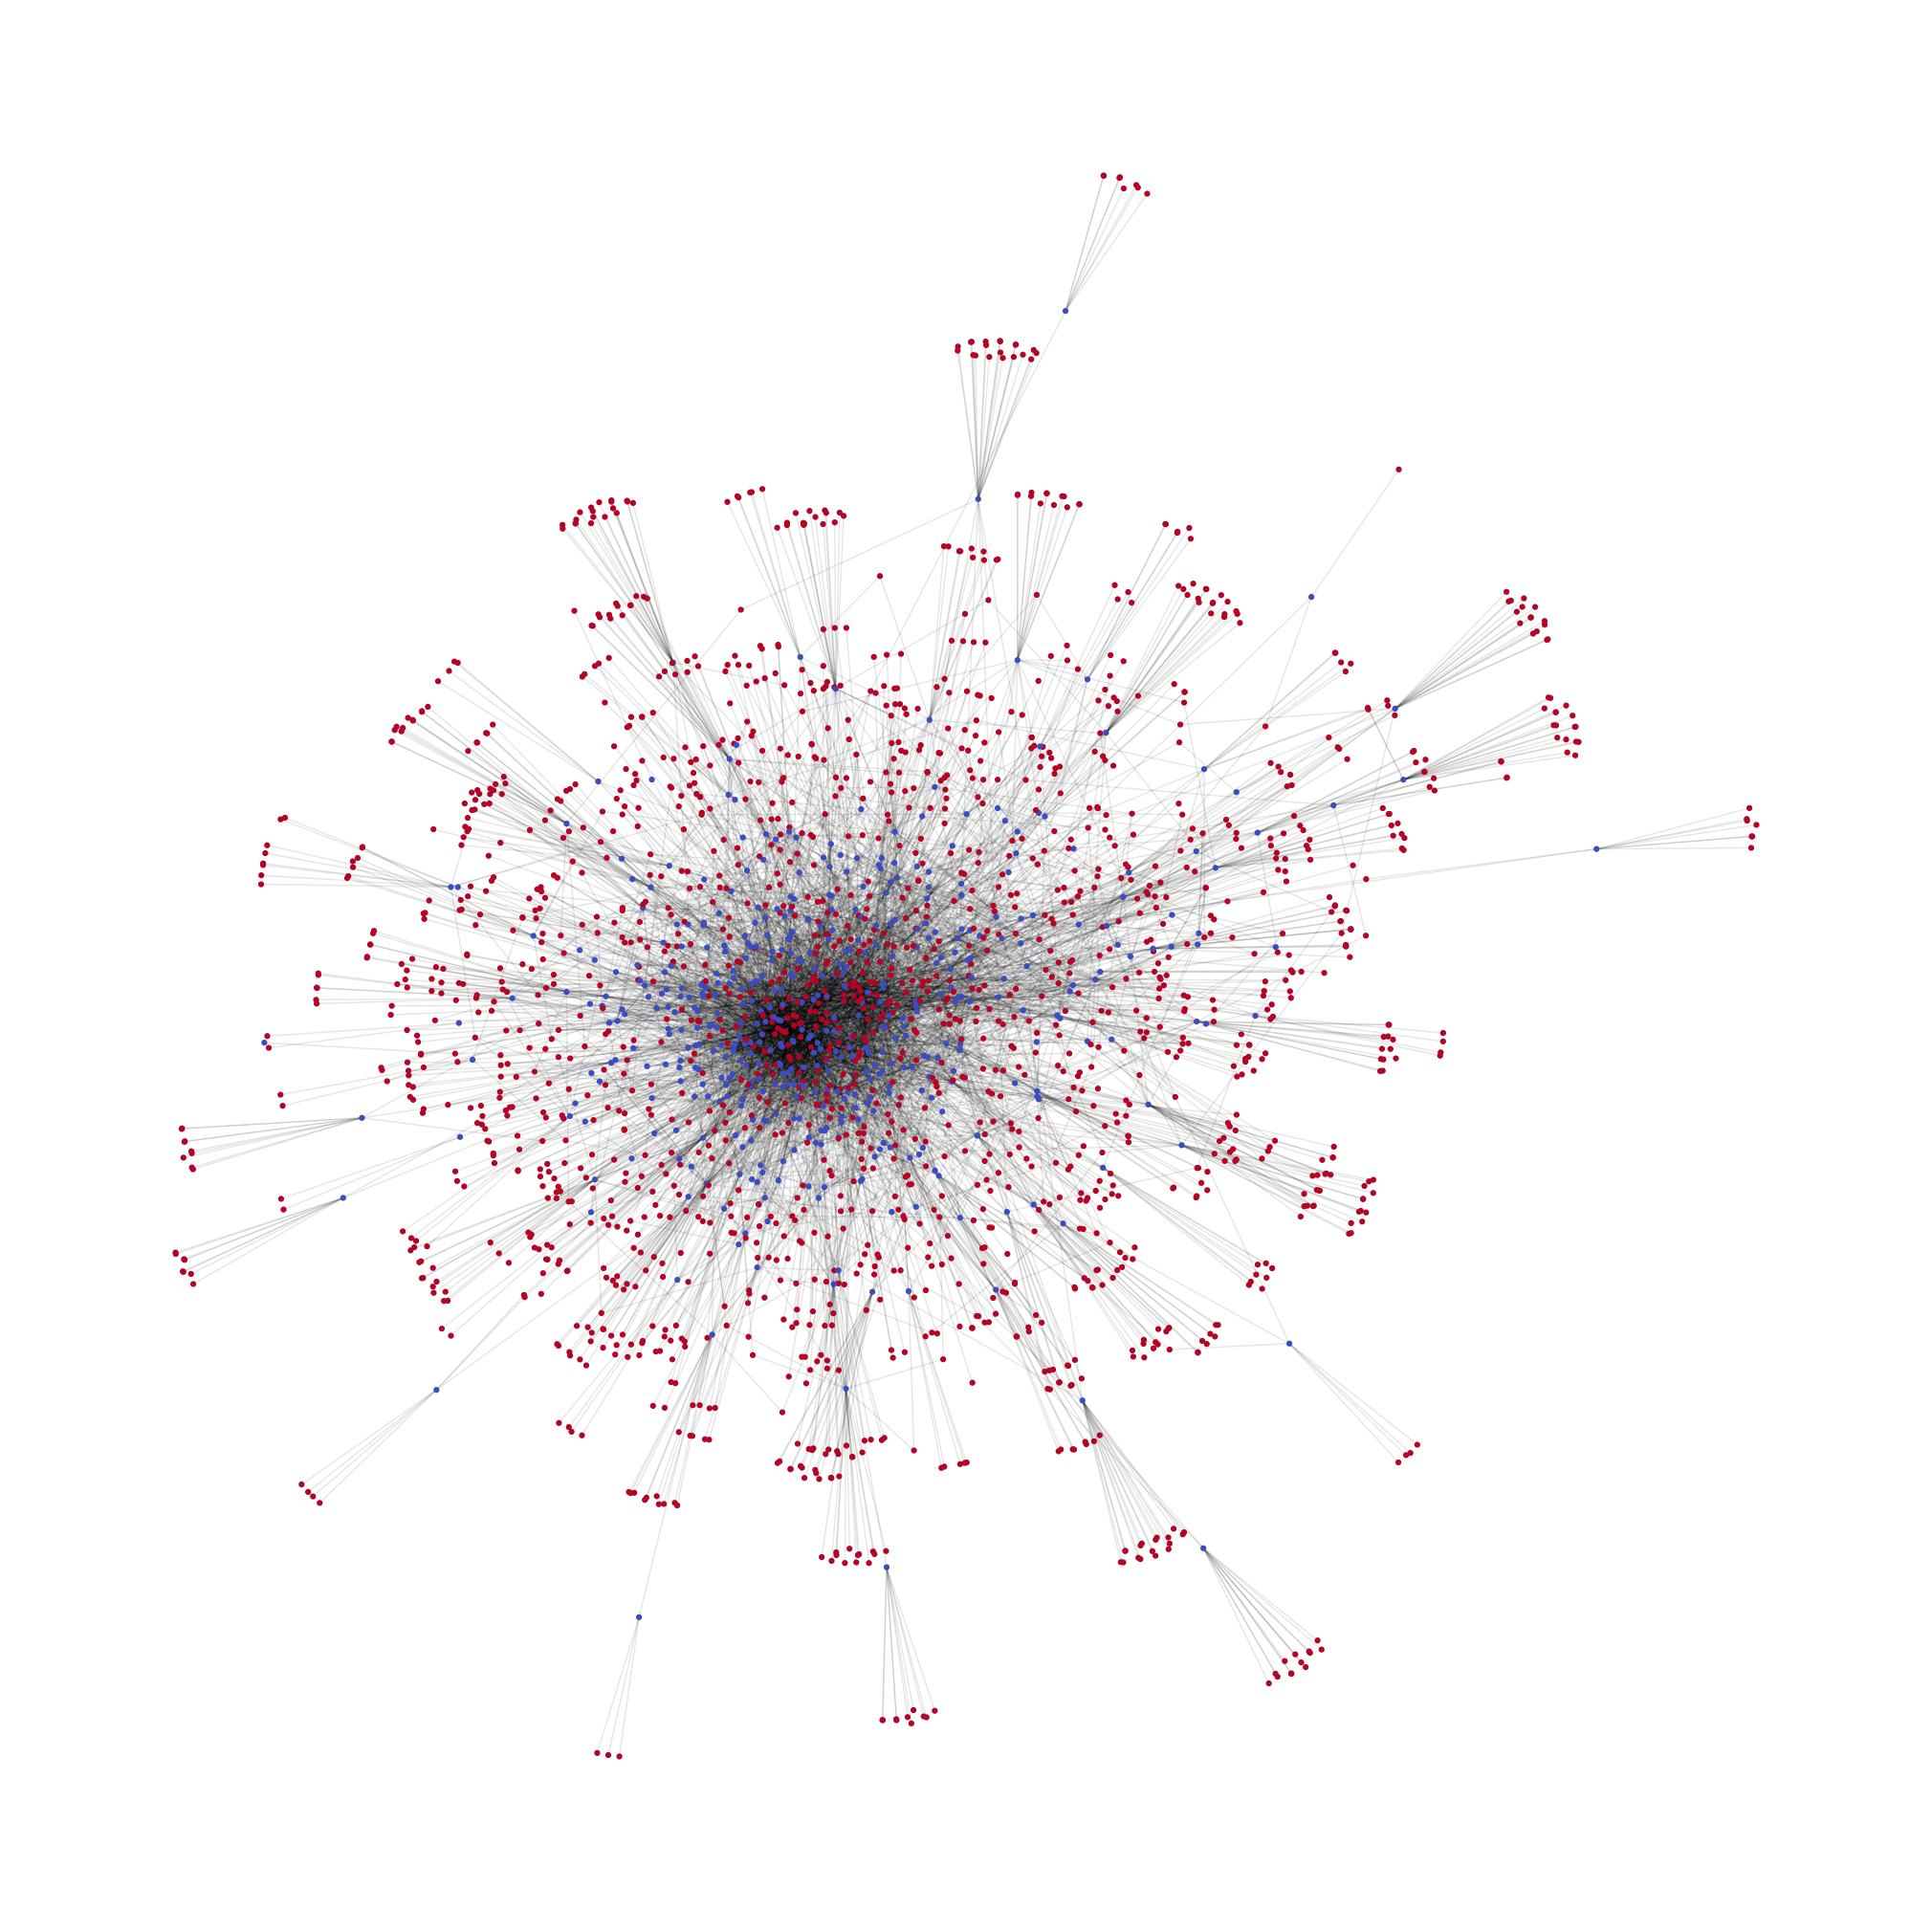

In [48]:
plt.figure(figsize=(20, 20))
color_map = {'playlist': 0, 'track': 1}
node_color = [color_map[attr['type']] for (id, attr) in subgraph.nodes(data=True)]
nx.draw(subgraph, cmap=plt.get_cmap('coolwarm'), node_color=node_color, node_size=12, width=1, edge_color=(0,0,0,0.1))

## **Optional: Adding Playlist Name Embeddings As Features**

Skip this step if you want to initalize the LightGCN embedding layer randomly from scratch (recommended).

We are using the popular [Paraphrase MiniLM L6 v2](https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2) model from HuggingFace to create 384-dimensional embeddings of playlist names to initialize the LightGCN embedding layer. The Paraphrase Mini model is very popular because it provides high quality textual embeddings for short sentences or words in only 384 dimensions.

### Initialize NLP Model

We will download the pre-trained text embedding model and illustrate some embedding examples.

In [49]:
ex1 = 'Throwbacks'
ex2 = 'Toxic'
ex3 = 'Love is great'

In [50]:
from transformers import AutoTokenizer, AutoModel

In [51]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [52]:
# Sentences we want sentence embeddings for
sentences = [ex1, ex2, ex3]

In [53]:
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/paraphrase-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [54]:
# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

In [55]:
# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

In [56]:
# Perform pooling. In this case, max pooling.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [57]:
print("Sentence embeddings:")
print(sentence_embeddings.shape)

Sentence embeddings:
torch.Size([3, 384])


Aren't HuggingFace transformers beautiful! We create 3 384-dimensional embeddings for our example sentences and words.

### Embed Track & Playlist Names

Now, we write a function to create embeddings for playlist names will generating a dummy feature with all ones for our track names.

In [58]:
import pandas as pd
from os.path import isfile, join

In [59]:
DATA_PATH = '/content/drive/MyDrive/CS 224W Project_50'

We import the dataframe we created to map playlist ids to names.

In [60]:
df_pos = pd.read_pickle(join(DATA_PATH, 'df_50_files.npz'))

This function creates the embeddings.

In [61]:
def embed_names(G, node_type, batch_size=None, ones=False):
    assert node_type == 'playlist' or node_type == 'track', 'Node type must be playlist or track.'
    EMBED_SIZE = 384

    # Get Names and IDs
    old_ids = [label for label, attr in G.nodes(data=True) if attr['type'] == node_type]
    ids = old_ids

    if ones:
        node_features = torch.ones(EMBED_SIZE)
        nx.set_node_attributes(G, node_features, 'node_feature')
        return

    if node_type == 'track':
        ids = [''.join(x.split(':')[2:]) for x in old_ids]

    short_form = 'plst' if node_type == 'playlist' else node_type
    lookup = df_pos[[f'{short_form}_id', f'{short_form}_name']].drop_duplicates().set_index(f'{short_form}_id')
    names = lookup.loc[ids][f'{short_form}_name'].tolist()

    batch_n = batch_size if batch_size is not None else len(names)
    for start_i in tqdm(range(0, len(names), batch_n)):
        end_i = start_i + batch_n
        name_batch = names[start_i:end_i]

        # Embed
        encoded_input = tokenizer(name_batch, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            model_output = model(**encoded_input)

        embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

        # Assign
        features = {id: {'node_feature': embeddings[j]} for j, id in enumerate(old_ids[start_i:end_i])}
        nx.set_node_attributes(G, features)

In [62]:
embed_names(G_ego, 'track')

  0%|          | 0/1 [00:00<?, ?it/s]

In [63]:
embed_names(G_ego, 'playlist')

  0%|          | 0/1 [00:00<?, ?it/s]

Save the embeddings if needed.

In [ ]:
pickle.dump(G_ego, open('/content/drive/MyDrive/CS224W/Data/ego_graph_features.txt', 'wb'))

## **Generate A DeepSnap Graph**

We need to convert our NetworkX object to a DeepSnap graph to profit from the library's link prediction dataset generation capabilities. We also strip unncessary attributes from the graph in order to reduce memory requirements. LightGCN only works on the graph structure itself and does not necessarily require node features, unless we want to initialize the embedding layer with specific features (i.e. our text embedding model).

In [ ]:
nodes = [id for id, attr in G_ego.nodes(data=True)]

In [ ]:
edges = [edge for edge in G_ego.edges()]

In [ ]:
G_ego = nx.Graph()

In [ ]:
G_ego.add_nodes_from(nodes)
G_ego.add_edges_from(edges)

In [ ]:
dg = Graph(G_ego)

## **Dataset Generation**

We generate datasets for training, validation, and prediction using DeepSnap. The task we select is link prediction which automatically samples a dataset of positive and negative edges used for training, validation, and prediction. It is important that we use the "disjoint mode" for prediction as we want message-flowing edges and prediction edges to be separate from each other.

In [ ]:
task = 'link_pred'
dataset = GraphDataset([dg], task=task, edge_train_mode='disjoint')

In [ ]:
print(f'The dataset has {dataset.num_edges[0]} edges.')

We use an 80%, 10%, 10% split between training, validation, and testing sets.

In [ ]:
# Split the dataset
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

In [ ]:
num_train_edges = dataset_train[0].edge_label_index.shape[1]
num_val_edges = dataset_val[0].edge_label_index.shape[1]
num_test_edges = dataset_test[0].edge_label_index.shape[1]

print("Train set has {} supervision (positive) edges".format(num_train_edges // 2))
print("Validation set has {} supervision (positive) edges".format(num_val_edges // 2))
print("Test set has {} supervision (positive) edges".format(num_test_edges // 2))

print("Train set has {} message passing edges".format(dataset_train[0].edge_index.shape[1]))
print("Validation set has {} message passing edges".format(dataset_val[0].edge_index.shape[1]))
print("Test set has {} message passing edges".format(dataset_test[0].edge_index.shape[1]))

We can execute the next lines to save our datasets to disk for easier retrieval.

In [ ]:
pickle.dump(dataset_train, open('/content/drive/MyDrive/CS224W/Data/train_homo_big.graph', 'wb'))
pickle.dump(dataset_val, open('/content/drive/MyDrive/CS224W/Data/val_homo_big.graph', 'wb'))
pickle.dump(dataset_test, open('/content/drive/MyDrive/CS224W/Data/test_homo_big.graph', 'wb'))

... and to load the data again:

In [ ]:
dataset_train = pickle.load(open('/content/drive/MyDrive/CS224W/Data/train_homo_big.graph', 'rb'))
dataset_val = pickle.load(open('/content/drive/MyDrive/CS224W/Data/val_homo_big.graph', 'rb'))
dataset_test = pickle.load(open('/content/drive/MyDrive/CS224W/Data/test_homo_big.graph', 'rb'))

## **Building LightGCN From Scratch**

Using the [LightGCN research paper](https://arxiv.org/pdf/2002.02126.pdf) we implemented the LightGCN model completely from scratch using Pytorch, PyTorch Geometric, and DeepSnap.

What is unique about LightGCN is that the only trainable parameters are the first layer's embeddings. LightGCN then propagates this information along the graph to optimize the embeddings.

We adjusted the original LightGCN model in the following ways:

1. The original LightGCN model outputs a rank (scalar) identifying the strength of a connection between a playlist and a track. Since we sampled positive and negative edges, we are not ranking them, but instead want to produce a predicted label. We achieved this by **changing the Bayesian Personalized Ranking (BPR) loss function to a Binary Cross-Entropy (BCE) loss**.

2. To make the model more accurate, we **added a Sigmoid layer**, transforming the ranking (a dot-product result) to a binary label.

3. We used a **normal mean aggregation instead of a weighted-sum mean aggregation** for our LightGCN convolutional layer because due to the structure of our graph, this would have given to much weight to individual tracks.

In [ ]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

### The Custom LightGCN Convolutional Layer

First, we need to build the LightGCN convolutional layer from scratch and define its specific message passing character. We need to do this because the layer is not a pre-defined PyTorch Geometric layer.

The following is the message passing function of our modified LightGCN Convolutional Layer:

\begin{equation}
h_v^{(l)} = AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

where $AGG(\cdot)$ is defined as:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

In [ ]:
class LightGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):
        super(LightGCNConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

    def forward(self, x, edge_index, size = None):
        out = self.propagate(edge_index, x=(x, x))
        return out

    def message(self, x_j):
        out = x_j
        return out

    def aggregate(self, inputs, index, dim_size = None):
        node_dim = self.node_dim
        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce='mean')
        return out

### The LightGCN Model

Next, let us build the LightGCN model which is a bit harder. The LightGCN model needs to be flexible enough for the following:

1. Different number of input nodes
2. Specify embedding dimensions
3. Specify the number of layers
4. Pre-initialize the embedding layer with pre-computed tensors

The modified version of our LightGCN model computes the final embeddings as a weighted-sum of each layer's embeddings:

\begin{equation}
h_v = \sum_{l=0}^{L} \alpha_l h_v^{l}
\end{equation}

where $\alpha_{l}$ can be appropriately chosen for every layer depending on the domain. Note that the initial layer-0 embedding is included in the weighted-sum average as well. In the original paper, $\alpha_{l}$ is uniformly defined for all layers as:

\begin{equation}
\alpha_{l} = \frac{1}{K + 1}
\end{equation}

and $K$ is the number of layers.

Finally, because we aren't computing ranking between playlists and tracks but instead a binary score predicting whether the edge exists or not, we change the original LightGCN prediction header (a simple dor product) to the following to obtain our final prediction $\hat{y}_{vu}$ for a playlist-track pair $vu$:

\begin{equation}
\hat{y}_{vu} = \sigma(h_v^T h_u)
\end{equation}

Here, $\sigma(\cdot)$ is defined to be the sigmoid function.

In [ ]:
class LightGCN(torch.nn.Module):
    def __init__(self, train_data, num_layers, emb_size=16, initialize_with_words=False):
        super(LightGCN, self).__init__()
        self.convs = nn.ModuleList()
        assert (num_layers >= 1), 'Number of layers is not >=1'
        for l in range(num_layers):
            self.convs.append(LightGCNConv(input_dim, input_dim))

        # Initialize using custom embeddings if provided
        num_nodes = train_data.node_label_index.size()[0]
        self.embeddings = nn.Embedding(num_nodes, emb_size)
        if initialize_with_words:
            self.embeddings.weight.data.copy_(train_datanode_features)

        self.loss_fn = nn.BCELoss()
        self.num_layers = num_layers
        self.emb_size = emb_size
        self.num_modes = num_nodes

    def forward(self, data):
        edge_index, edge_label_index, node_label_index = data.edge_index, data.edge_label_index, data.node_label_index
        layer_embeddings = []

        x = self.embeddings(node_label_index)
        mean_layer = x

        # We take an average of ever layer's node embeddings
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            mean_layer += x

        mean_layer /= 4

        # Prediction head is simply dot product
        nodes_first = torch.index_select(x, 0, edge_label_index[0,:].long())
        nodes_second = torch.index_select(x, 0, edge_label_index[1,:].long())

        # Since we don't want a rank output, we create a sigmoid of the dot product
        out = torch.sum(nodes_first * nodes_second, dim=-1) # FOR RANKING
        pred = torch.sigmoid(out)

        return torch.flatten(pred)

    def loss(self, pred, label):
        return self.loss_fn(pred, label)

## **Define Training & Test Functions**

Next, we need to define the hyperparameters and datasets our model should use. We programmed everything in a way so that in easily runs on GPUs in Google Colab or CPU, whatever is preferred.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers' : 3,
    'emb_size' : 32,
    'epochs' : 1,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 300
}

datasets = {
    'train': dataset_train[0],
    'val': dataset_val[0],
    'test': dataset_test[0]
}

input_dim = datasets['train'].num_node_features
print(input_dim, args)

In [ ]:
datasets['train'].to(args['device'])
datasets['val'].to(args['device'])
datasets['test'].to(args['device'])

Finally, define training and test functions which save the loss and our chosen metrics.

For our metrics, we chose to use the area-under-the-curve (ROC-AUC) of whether a given playlist and track belong together or not in a balanced dataset.

In [ ]:
losses = []

def train(model, optimizer, args):
    val_max = 0
    best_model = model

    for epoch in range(1, args['epochs'] + 1):
        datasets['train'].to(args["device"])
        model.train()
        optimizer.zero_grad()
        pred = model(datasets['train'])
        loss = model.loss(pred, datasets['train'].edge_label.type(pred.dtype))

        loss.backward()
        optimizer.step()

        log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Loss: {:.5f}, Val Loss: {:.5f}'
        score_train, train_loss = test(model, 'train', args)
        score_val, val_loss = test(model, 'val', args)
        score_test, test_loss = test(model, 'test', args)

        losses.append((train_loss, val_loss))

        print(log.format(epoch, score_train, score_val, score_test, train_loss, val_loss))
        if val_max < score_val:
            val_max = score_val
            best_model = copy.deepcopy(model)

    return best_model

def test(model, mode, args):
    model.eval()
    score = 0
    loss_score = 0

    data = datasets[mode]
    data.to(args["device"])

    pred = model(data)
    loss = model.loss(pred, data.edge_label.type(pred.dtype))
    score += roc_auc_score(data.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
    loss_score += loss.item()

    return score, loss_score

## **Start Training**

We know - we can't wait either! Go ahead and run the model using your parameters of choice.

In [ ]:
model = LightGCN(datasets['train'], args['num_layers'], emb_size=args['emb_size']).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

best_model = train(model, optimizer, args)
log = "Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Val Loss: {:.5f}, Test Loss: {:.5f}"
best_train_roc, train_loss = test(best_model, 'train', args)
best_val_roc, val_loss = test(best_model, 'val', args)
best_test_roc, test_loss = test(best_model, 'test', args)
print(log.format(best_train_roc, best_val_roc, best_test_roc, train_loss, val_loss, test_loss))

This looks absolutely beautiful. As you can see, our best model gets low validation and test losses and high train, validation, and test ROC-AUCs. Also, our model doesn't seem to overfit.

Let's now save the best model for later retrieval:

In [ ]:
pickle.dump(best_model, open('/content/drive/MyDrive/CS224W/Data/best_model_big.model', 'wb'))

## **Evaluation**

It's always nice to plot how our model did during training. Let's program a function which quickly visualizes our training and validation loss curves.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def plot_learning_curve(losses, title):
    train_loss, val_loss = zip(*losses)
    steps = list(range(1, len(train_loss) + 1))

    min_val_loss = np.round(np.min(val_loss), 3)

    plt.figure(figsize=(16, 6))
    plt.plot(steps, train_loss, '-r', label='Training Loss')
    plt.plot(steps, val_loss, '-b', label='Validation Loss')
    plt.hlines(min_val_loss, 1, 300, colors='k', linestyles='dotted', label='Min Validation Loss: {}'.format(min_val_loss))

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim((0.58, 0.71))
    plt.title(title)
    plt.legend(loc='upper right')
    plt.title(title)

    return plt

In [ ]:
plot_learning_curve(losses, 'LightGCN on Spotify Popular Playlist 3-Hop Neighborhood')

## **Final Remarks**

Congrats! You created a graph ML model which does neural collaborative filtering on Spotify playlists and tracks to predict whether a given track belongs to a playlist or not.

You could use your model to test a number of tracks against your own playlists just on the basis of what similar people to you like.